In [26]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional,Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 1000)

In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:5000,:]

In [6]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Tom is a poet.', 'Tom ist ein Poet.'],
       ['Tom is a slob.', 'Tom ist ein Chaot.'],
       ['Tom is a wimp.', 'Tom ist ein Weichei.']], dtype='<U380')

In [7]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Tom is a poet', 'Tom ist ein Poet'],
       ['Tom is a slob', 'Tom ist ein Chaot'],
       ['Tom is a wimp', 'Tom ist ein Weichei']], dtype='<U380')

In [8]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['tom is a poet', 'tom ist ein poet'],
       ['tom is a slob', 'tom ist ein chaot'],
       ['tom is a wimp', 'tom ist ein weichei']], dtype='<U380')

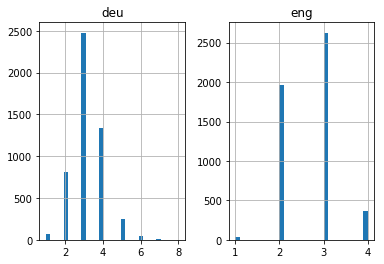

In [9]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1391


In [12]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 2330


In [13]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
def model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(Bidirectional(LSTM(units)))
      model.add(RepeatVector(out_timesteps))
      model.add(Bidirectional(LSTM(units, return_sequences=True)))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
model = model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(lr=0.001,rho=0.8)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'model_file'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=256, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 46s 14ms/step - loss: 3.5342 - val_loss: 2.0608

Epoch 00001: val_loss improved from inf to 2.06079, saving model to model_file
Epoch 2/30
3200/3200 [==============================] - 40s 12ms/step - loss: 2.0121 - val_loss: 1.9879

Epoch 00002: val_loss improved from 2.06079 to 1.98790, saving model to model_file
Epoch 3/30
3200/3200 [==============================] - 40s 12ms/step - loss: 1.8958 - val_loss: 1.9056

Epoch 00003: val_loss improved from 1.98790 to 1.90558, saving model to model_file
Epoch 4/30
3200/3200 [==============================] - 41s 13ms/step - loss: 1.7964 - val_loss: 1.8569

Epoch 00004: val_loss improved from 1.90558 to 1.85693, saving model to model_file
Epoch 5/30
3200/3200 [==============================] - 40s 12ms/step - loss: 1.7189 - val_loss: 1.8149

Epoch 00005: val_loss improved from 1.85693 to 1.81490, saving model to model_file
Epoch 6/30
3200/3

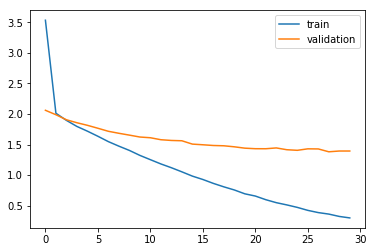

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('model_file')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [22]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [23]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0],'German':test[:,1] ,'predicted' : preds_text})

In [25]:
pred_df.sample(15)

,German,actual,predicted
515,ich werde es verwenden,ill use it,ill allow it
76,mach es für tom,do it for tom,let it
463,du drückst dich vage aus,youre vague,try down
322,mach dich vom acker,go away,get it
850,ich habe kaffee gekocht,i made coffee,i got coffee
101,das gehört mir,thats mine,thats me
332,schwirr ab,get lost,go away
281,sie weint,she is crying,start down
905,in deckung,get down,take mine
455,halten sie sich warm,keep warm,stop thanks
